<a href="https://colab.research.google.com/github/Matheus-Homem/russian_weekly_sales/blob/main/notebooks/%5BCRISP_DS_2nd_cycle%5D_Russian_Store_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

## 0.1. Libraries

In [326]:
# Importing Number Processing Libraries
import numpy as np
from scipy import stats
from scipy.special import boxcox, inv_boxcox

# Importing Data Manipulation Libraries
import pandas as pd

# Importing Data Formatting Libraries
from tabulate import tabulate
from pprint import pprint

# Importing Data Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import cm
import seaborn as sns
sns.set_style('darkgrid')
!pip install joypy
from joypy import joyplot

# Importing Date Processing Libraries
import datetime

# Importing Data Pre Processing Libraries
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
!pip install boruta
from boruta import BorutaPy

# Importing Machine Learning Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
!pip install xgboost
import xgboost as xgb

# Importing Error Metrics Libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Importing Optimization Methods Libraries
from sklearn.model_selection import RandomizedSearchCV
import random

In [327]:
import warnings
warnings.filterwarnings('ignore')

In [328]:
# Colors
viridis = cm.get_cmap('viridis', 12)(0.2)
viridis2 = cm.get_cmap('viridis', 12)(0.6)

# Setting numbers displaying
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 0.2. Loading Data

In [329]:
# Importing data from .csv
item_categories = pd.read_csv("https://github.com/Matheus-Homem/future-sales-prediction/raw/main/data/item_categories%20(translated).csv")
items = pd.read_csv("https://github.com/Matheus-Homem/future-sales-prediction/raw/main/data/items%20(translated).csv")
sales_train = pd.read_csv("https://github.com/Matheus-Homem/future-sales-prediction/raw/main/data/sales_train.csv")
shops = pd.read_csv("https://github.com/Matheus-Homem/future-sales-prediction/raw/main/data/shops%20(translated).csv")
holidays = pd.read_csv("https://github.com/Matheus-Homem/russian_weekly_sales/raw/main/data/russian_holidays.csv")

In [330]:
# First row of 'item_categories'
item_categories.loc[0]

item_category_name         PC - Гарнитуры/Наушники
item_category_name_en    PC - Headset / Headphones
item_category_id                                 0
Name: 0, dtype: object

In [331]:
# First row of 'items'
items.loc[0]

item_name                ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
item_name_en        Lucky In the power of the puffy (reservoir.) D
item_id                                                          0
item_category_id                                                40
Name: 0, dtype: object

In [332]:
# First row of 'sales_train'
sales_train.loc[0]

date              02.01.2013
date_block_num             0
shop_id                   59
item_id                22154
item_price            999.00
item_cnt_day            1.00
Name: 0, dtype: object

In [333]:
# First row of 'shops'
shops.loc[0]

shop_name          !Якутск Орджоникидзе, 56 фран
shop_name_en    ! Yakutsk Ordzhonikidze, 56 fran
shop_id                                        0
Name: 0, dtype: object

In [334]:
# First row of 'holidays'
holidays.loc[0]

Day                       Friday
Date                     jan. 01
Holiday Name      New Year's Day
Type            National Holiday
Comments                     NaN
Name: 0, dtype: object

## 0.3. Helper Functions

In [335]:
# Axes label formatter
def format_number(data_value,indx):
  if data_value >= 1000000000:
    formatter = '{:1.1f}B'.format(data_value*0.000000001)
  elif (data_value < 1000000000) & (data_value >= 10000000):  
    formatter = '{:1.0f}M'.format(data_value*0.000001)
  elif (data_value < 10000000) & (data_value >= 1000000):  
    formatter = '{:1.1f}M'.format(data_value*0.000001)
  else:
    formatter = '{:1.0f}K'.format(data_value*0.001)
  return formatter

In [336]:
def cramer_v(x,y):
  # Creating Confusion Matrix
  cm = pd.crosstab(x,y).values
  # Performing Chi² Test from the confusion matrix
  chi2 = stats.chi2_contingency(cm)[0]
  # Adding all values from confusion matrix
  n = cm.sum()
  # Getting the dimensions of the confusion matrix
  r,k = cm.shape

  # Correcting Values
  chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)

  # Appling Cramér's V
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

In [337]:
def mean_absolute_percentage_error(y,yhat):
  return np.mean(np.abs((y - yhat)/y))

In [338]:
def ml_error(model_name,y,yhat):
  mae = mean_absolute_error(y,yhat)
  mape = mean_absolute_percentage_error(y,yhat)
  rmse = np.sqrt(mean_squared_error(y,yhat))

  return pd.DataFrame({'Model Name': model_name,
                       'MAE': mae,
                       'MAPE': mape,
                       'RMSE': rmse}, index=[0])

In [339]:
def cross_validation(x_training,kfold,model_name,model,verbose=False):

  mae_list = []
  mape_list = []
  rmse_list = []
  for k in reversed(range(1,kfold+1)):
    if verbose:
      print('\nKFold Number: {}'.format(k))
    # Start and end date for validation
    validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*3*30)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*3*30)

    # Filtering Dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    # Training and Validation dataset
    # training
    xtraining = training.drop(['date','sales'],axis=1)
    ytraining = training['sales']

    # validation
    xvalidation = validation.drop(['date','sales'],axis=1)
    yvalidation = validation['sales']

    # Model
    m = model.fit(xtraining,ytraining)

    # Prediction
    yhat = m.predict(xvalidation)

    # Performance
    result = ml_error(model_name, np.expm1(yvalidation),np.expm1(yhat))
    
    # Storing performance of each iterarion
    mae_list.append(result['MAE'])
    mape_list.append(result['MAPE'])
    rmse_list.append(result['RMSE'])

  return pd.DataFrame( {'Model Name': model_name,
                        'MAE Mean': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                        'MAPE Mean': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                        'RMSE Mean': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

# 1. Data Description

## 1.1. Merging Tables

In [340]:
df1 = pd.merge(items,item_categories,on='item_category_id')
df1 = pd.merge(sales_train,df1,on='item_id')
df1 = pd.merge(df1,shops,on='shop_id')

cols_drop = ['item_name','item_category_name','shop_name']
df1 = df1.drop(cols_drop, axis=1)

df1.rename(columns={'item_name_en': 'item_name',
                   'item_category_name_en': 'item_category_name',
                   'shop_name_en': 'shop_name'},
                   inplace=True)

df1.sample().T

,2656293
date,04.06.2013
date_block_num,5
shop_id,43
item_id,7288
item_price,399.00
item_cnt_day,1.00
item_name,V / A Cafe Del Mar Ibiza Vol? Men Cinco Y SEIS...
item_category_id,55
item_category_name,Music - Local CD CD
shop_name,"SPb TK ""SENS"""


## 1.2. Data Dimensions

In [341]:
print('Number of Rows: {:,}'.format(df1.shape[0]))
print('Number of Columns: ',df1.shape[1])

Number of Rows: 2,935,849
Number of Columns:  10


## 1.3. Data Types

In [342]:
df1.dtypes

date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
item_name              object
item_category_id        int64
item_category_name     object
shop_name              object
dtype: object

## 1.4. Change Data Types

In [343]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.5. NA Checking

In [344]:
df1.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

## 1.6. Fillout NA

- None of the columns have null values;

## 1.7. Outliers Checking

### 1.7.1. Item_cnt_day

In [345]:
df1['item_cnt_day'].sort_values(ascending=False)

2437569   2169.00
2440986   1000.00
2459127    669.00
2934267    637.00
2458633    624.00
            ...  
2436415     -6.00
1025359     -6.00
2452070     -9.00
2295713    -16.00
2433292    -22.00
Name: item_cnt_day, Length: 2935849, dtype: float64

In [346]:
df1 = df1[(df1['item_cnt_day']>0) & (df1['item_cnt_day']<1000)]

### 1.7.2. Item_price

In [347]:
df1['item_price'].sort_values(ascending=False)

2448552   307980.00
2436534    59200.00
341522     50999.00
2457649    49782.00
2460639    42990.00
             ...   
416138         0.09
1668409        0.09
418687         0.07
1664685        0.07
2717783       -1.00
Name: item_price, Length: 2928491, dtype: float64

In [348]:
df1 = df1[(df1['item_price']>0) & (df1['item_price']<=60000)]

## 1.8. Descriptive Statistical

In [349]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [350]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Contacatenate
n = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
n.columns = ['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']

In [351]:
n

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,date_block_num,0.00,33.00,33.00,14.57,14.00,9.42,0.20,-1.08
1,shop_id,0.00,59.00,59.00,33.00,31.00,16.23,-0.07,-1.02
2,item_id,0.00,22169.00,22169.00,10200.28,9355.00,6324.39,0.26,-1.23
3,item_price,0.07,59200.00,59199.93,889.36,399.00,1718.15,9.00,109.91
4,item_cnt_day,1.00,669.00,668.00,1.25,1.00,2.22,100.33,20211.33
5,item_category_id,0.00,83.00,83.00,40.02,40.00,17.10,0.32,-0.53


### 1.7.2. Categorical Attributes

In [352]:
# Unique values
cat_attributes.apply(lambda x: x.unique().shape[0])

item_name             21716
item_category_name       84
shop_name                60
dtype: int64

# 2. Feature Engineering

In [353]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

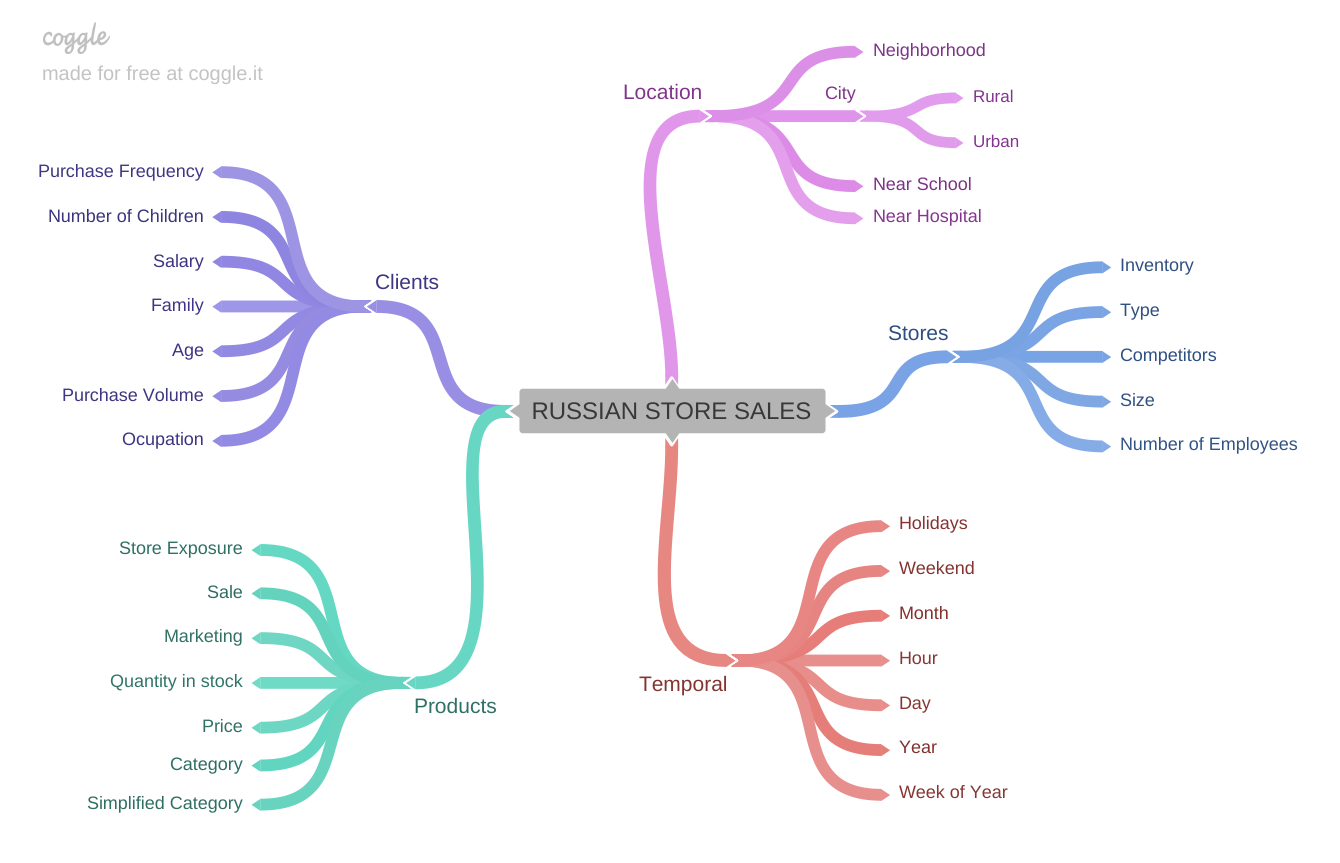

## 2.2. List of Hypothesis

**01.** Stores should sell more over the years

**02.** Stores should sell more in the second semester

**03.** Stores should sell more in the first half of the month

**04.** Stores should sell more on weekends

**05.** Stores located in Moscow should sell more

**06.** Shopping Center type stores should sell more

**07.** Stores should sell less on holidays

**08.** Stores with more item variety should sell more

**09.** Stores with higher sums of average prices should sell more

## 2.3. Feature Engineering

### 2.3.1. Main Dataframe

In [354]:
# Studying item_cnt_day
print('Feature item_cnt_day has {} values equal to 0 and {} values less than 0;'.format(df2[df2['item_cnt_day']==0].shape[0],df2[df2['item_cnt_day']<0].shape[0]))
# Since a store cannot sell negative amounts of items, we will assume that such amounts mean 0
df2['item_cnt_day'] = list(map(lambda x: 0 if x<0 else x, df2['item_cnt_day']))

Feature item_cnt_day has 0 values equal to 0 and 0 values less than 0;


In [355]:
# Grouping item categories
unique_categories = list(df2['item_category_name'].unique())
unique_categories.sort()
simple_categories = list(map(lambda x: x.split('-')[0], unique_categories))
simple_categories = list(map(lambda x: x.split('(')[0].rstrip(), simple_categories))
category_dict = dict(zip(unique_categories, simple_categories))
df2['simple_categories'] = df2['item_category_name'].map(category_dict)

# Extracting city name from shop name
unique_shops = df2['shop_name'].unique()
unique_shops.sort()
cities = unique_shops.copy()
cities[:2] = list(map(lambda x: x[2:],cities[:2]))
cities = list(map(lambda x: x.split(' ')[0],cities))
cities[2] = cities[2][3:]
cities = list(map(lambda x: x.capitalize(),cities))
cities_dict = dict(zip(unique_shops, cities))
df2['city'] = df2['shop_name'].map(cities_dict)

# Extracting shop type from shop name
types_list = list(map(lambda x: x.split()[1], unique_shops))
type_dict = {'"Sale"':'None',
             'Yakutsk':'Shopping Center',
             '(Plekhanovskaya,':'None',
             'MTRC':'TRC',
             'Ordzhonikidze,':'None',
             'Posad':'Shopping Center',
             'Store':'None',
             'TC':'TC',
             'TK':'TK',
             'TPC':'TPC',
             'TRC':'TRC',
             'TRK':'TRK',
             'digital':'Digital',
             'shopping':'Shopping Center',
             'st.':'None',
             'store':'None',
             'trade':'None'}
type_list = [*map(type_dict.get,types_list)]
shop_type_dict = dict(zip(unique_shops, type_list))
df2['shop_type'] = df2['shop_name'].map(shop_type_dict)

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# day of week
df2['day_of_week'] = df2['date'].dt.weekday

# Creating the response variable 'sales' which represents the daily sale of each store
## Creating a variable that contains the obtained value
df2['value'] = df2['item_price'] * df2['item_cnt_day']
## Creating a dataframe that sums all values ​​grouping by date and store
daily_sales_df = df2[['date','shop_name','value']].groupby(['shop_name','date']).sum().reset_index()
## Similar columns to transfer information and dict
daily_sales_df['dict'] = daily_sales_df['shop_name'] + daily_sales_df['date'].astype(str)
df2['dict'] = df2['shop_name'] + df2['date'].astype(str)
sales_dict = dict(zip(daily_sales_df['dict'], daily_sales_df['value']))
## Mapping dict to new column
df2['sales'] = df2['dict'].map(sales_dict)
df2.drop(['dict','value'],axis=1,inplace=True)

### 2.3.2. Holidays Dataframe

In [356]:
d = {'jan.':1,
     'Feb':2,
     'mar.':3,
     'May':5,
     'jun.':6,
     'nov.':11,
     'Dec':12}
holidays['Month'] = holidays['Date'].map(lambda x: x.split(' ')[0]).map(d)
holidays['Day'] = holidays['Date'].map(lambda x: x.split(' ')[1]).astype(int)

In [357]:
aux1 = holidays[holidays['Type']=='National Holiday'][['Day','Month']]
aux1 = pd.concat([pd.to_datetime(aux1.assign(Year=2013).loc[:, ['Year','Month','Day']]),
                  pd.to_datetime(aux1.assign(Year=2014).loc[:, ['Year','Month','Day']]),
                  pd.to_datetime(aux1.assign(Year=2015).loc[:, ['Year','Month','Day']])], ignore_index=True)
aux1 = pd.DataFrame({'date':aux1,'holidays':np.ones(63)})
holidays_dict = dict(zip(aux1['date'], aux1['holidays']))
df2['holiday'] = df2['date'].map(holidays_dict)
df2['holiday'].fillna(0,inplace=True)
df2['holiday'] = df2['holiday'].astype(int)

In [358]:
df2.sample().T

,2574977
date,2015-12-07 00:00:00
date_block_num,30
shop_id,53
item_id,21395
item_price,299.00
item_cnt_day,1.00
item_name,The owner of the seas. On the edge of the eart...
item_category_id,37
item_category_name,Cinema - Blu-ray
shop_name,"Ufa TC ""Family"" 2"


# 3. Feature Filtering

In [380]:
df3 = df2.copy()

## 3.1. Columns Filtering

In [381]:
cols_drop = ['shop_id','item_category_name','simple_categories','item_id','item_category_id','date_block_num','item_cnt_day']
df3.drop(cols_drop,axis=1,inplace=True)
list(df3.columns)

['date',
 'item_price',
 'item_name',
 'shop_name',
 'city',
 'shop_type',
 'year',
 'month',
 'day',
 'week_of_year',
 'year_week',
 'day_of_week',
 'sales',
 'holiday']

## 3.2. Rows Filtering

In [382]:
# Filtering excessive item lines
df3 = df3.groupby(['shop_name','date','city','shop_type','year_week']).agg({'item_price':'sum',
                                                                            'item_name':'count',
                                                                            'year':'mean',
                                                                            'month':'mean',
                                                                            'day':'mean',
                                                                            'week_of_year':'mean',
                                                                            'day_of_week':'mean',
                                                                            'sales':'mean',
                                                                            'holiday':'mean'}).reset_index()

In [383]:
df3 = df3[df3['sales'] > 0]

In [433]:
df3[df3['date']<='2015-11-10']

,shop_name,date,city,shop_type,year_week,item_price,item_name,year,month,day,week_of_year,day_of_week,sales,holiday
1016,1c-online digital warehouse,2015-11-10,Online,Digital,2015-45,38045.00,43,2015,11,10,46,1,55249.00,0
2034,"Adygea shopping center ""Mega""",2015-11-10,Adygea,Shopping Center,2015-45,36239.00,30,2015,11,10,46,1,38787.00,0
3062,"Balashiha TRK ""October-Kinomir""",2015-11-10,Balashiha,TRK,2015-45,25229.00,18,2015,11,10,46,1,28228.00,0
4092,"Chekhov shopping center ""Carnival""",2015-11-10,Chekhov,Shopping Center,2015-45,77687.00,58,2015,11,10,46,1,85700.00,0
5137,"Kaluga TPC ""XXI Century""",2015-11-10,Kaluga,TPC,2015-45,57494.00,43,2015,11,10,46,1,63497.00,0
6736,"Kazan shopping center ""Parkhouse"" II",2015-11-10,Kazan,Shopping Center,2015-45,32603.00,34,2015,11,10,46,1,32962.00,0
8585,"Kolomna TC ""Rio""",2015-11-10,Kolomna,TC,2015-45,89585.00,57,2015,11,10,46,1,110395.00,0
9611,"Krasnoyarsk TC ""June""",2015-11-10,Krasnoyarsk,TC,2015-45,91455.00,53,2015,11,10,46,1,91455.00,0
11232,"Kursk shopping center ""Pushkinsky""",2015-11-10,Kursk,Shopping Center,2015-45,68018.00,70,2015,11,10,46,1,68721.00,0
12271,"Moscow MTRC ""AFI MALL""",2015-11-10,Moscow,TRC,2015-45,86536.00,45,2015,11,10,46,1,88947.00,0


# 4. Exploratory Data Analysis (EDA)

In [398]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

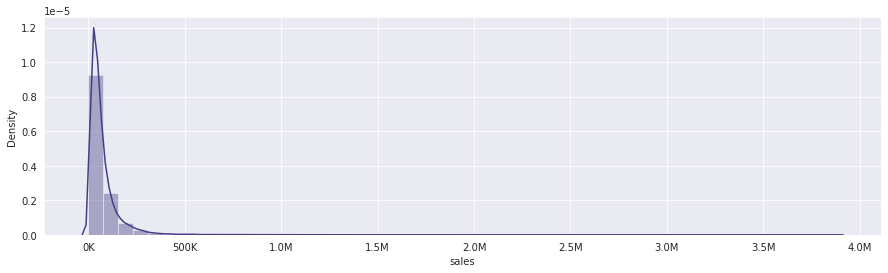

In [364]:
#@title Distribution Plot of Sales Variable
plt.figure(figsize=(15,4))
g = sns.distplot(df4['sales'],color=viridis)
g.xaxis.set_major_formatter(tick.FuncFormatter(format_number))
plt.show()

### 4.1.2. Numerical Variables

In [365]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

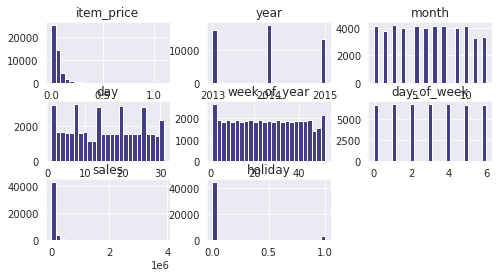

In [366]:
#@title Histograms of all Original Numerical Variables
num_attributes.hist(bins=25,figsize=(8,4),color=viridis);

### 4.1.3. Categorical Variables

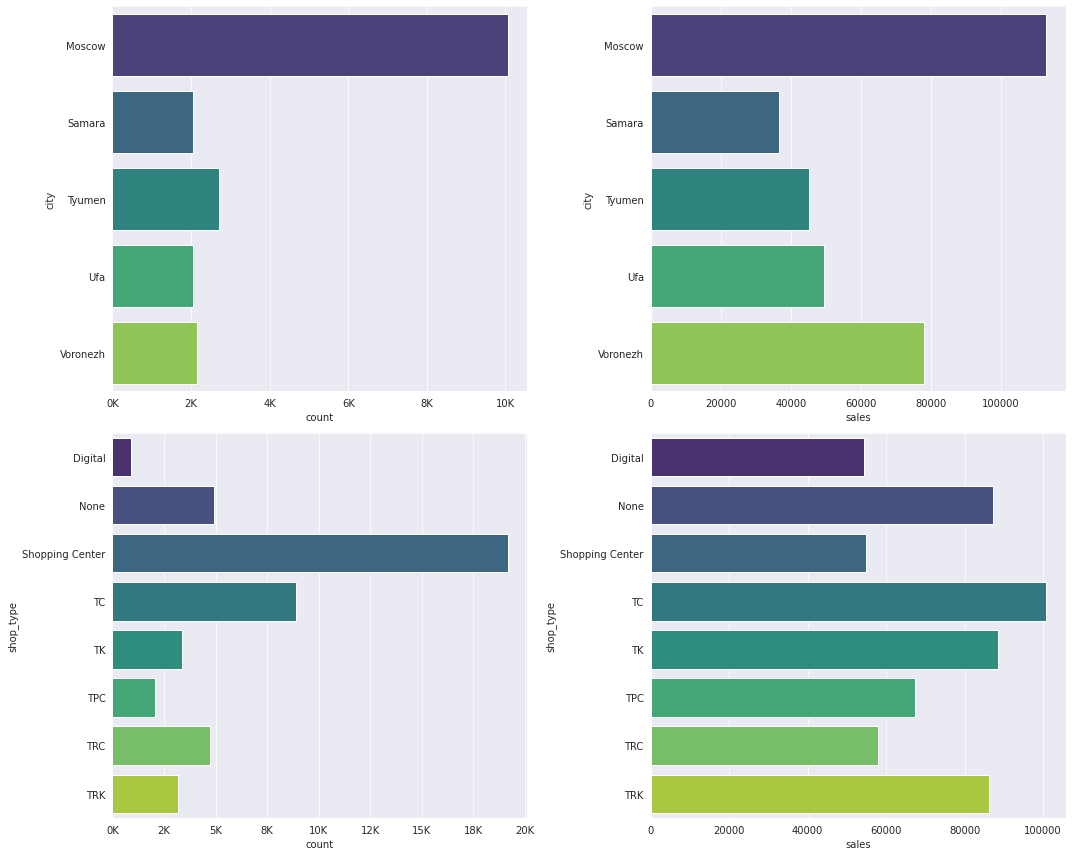

In [367]:
#@title Barplot and countplot for most frequent cities and shop_types
f, axes = plt.subplots(2,2,figsize=(15,12))

# city
aux1 = sorted(list(df4['city'].value_counts().index)[:5])
sns.countplot(y = df4[df4['city'].isin(aux1)]['city'],
              order = aux1,
              palette = 'viridis',
              ax = axes[0,0])
axes[0,0].xaxis.set_major_formatter(tick.FuncFormatter(format_number))

sns.barplot(data = df4[df4['city'].isin(aux1)][['city','sales']].groupby('city').mean().reset_index(),
            y = 'city',
            x = 'sales',
            palette = 'viridis',
            order = aux1,
            ax = axes[0,1])

# shop_type
aux2 = sorted(list(df4['shop_type'].unique()))
sns.countplot(y = df4['shop_type'],
              order = aux2,
              palette = 'viridis',
              ax = axes[1,0])
axes[1,0].xaxis.set_major_formatter(tick.FuncFormatter(format_number))

sns.barplot(data = df4[['shop_type','sales']].groupby('shop_type').mean().reset_index(),
            y = 'shop_type',
            x = 'sales',
            palette = 'viridis',
            order = aux2,
            ax = axes[1,1])

plt.tight_layout()
plt.show()

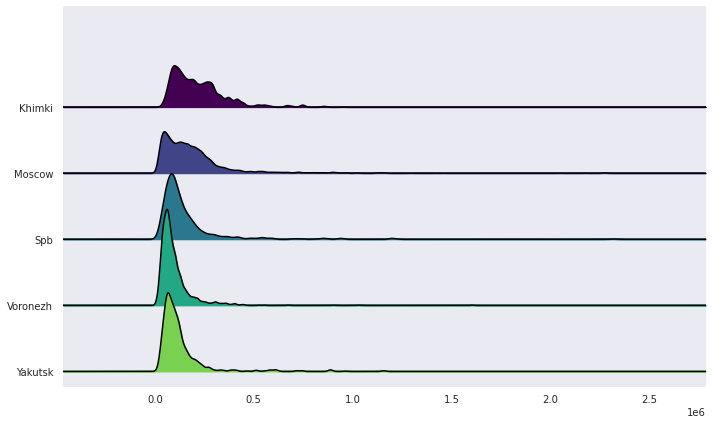

In [171]:
#@title Ridgeline Plot of Sales in different cities
joyplot(
    data=df4[df4['city'].isin(aux1)][['sales','city']],
    by='city',
    colormap=plt.cm.viridis,
    figsize=(10,6))

plt.show()

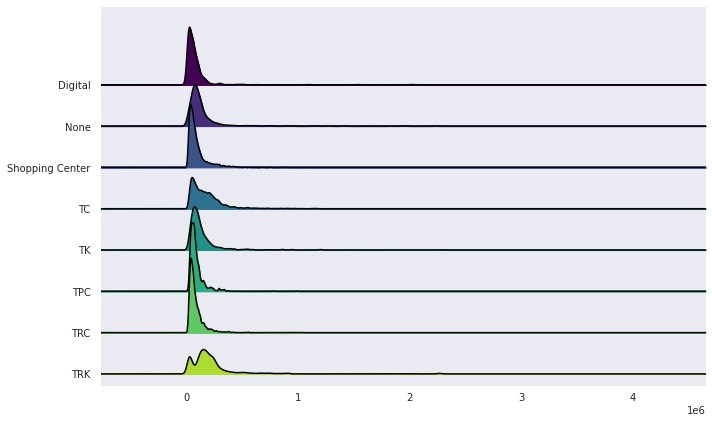

In [169]:
#@title Ridgeline Plot of Sales in different shop types
joyplot(
    data=df4[['sales','shop_type']],
    by='shop_type',
    colormap=plt.cm.viridis,
    figsize=(10,6))

plt.show()

## 4.2. Bivariate Analysis

### $H_{1}:$ Stores should sell more over the years
**FALSE** $\Rightarrow$ Stores sell LESS OVER THE YEARS

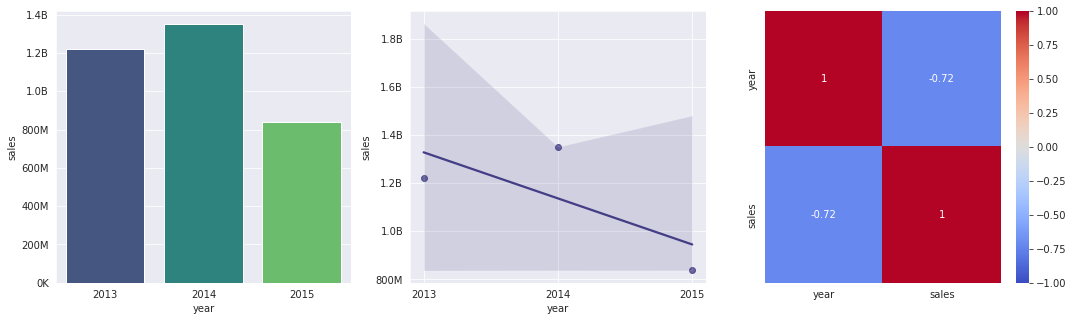

In [369]:
#@title Plot and Correlation of Sales x Years
plt.figure(figsize=(18,5))

aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
g1 = sns.barplot(x='year',y='sales',data=aux1,palette='viridis')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,2)
g2 = sns.regplot(x='year',y='sales',data=aux1,color=viridis)
g2.yaxis.set_major_formatter(tick.FuncFormatter(format_number))
g2.set_xticks([2013,2014,2015])

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True,cmap='coolwarm',vmin=-1)

plt.show()

### $H_{2}:$ Stores should sell more in the second semester
**FALSE** $\Rightarrow$ Stores sell MORE on the SECOND SEMESTER

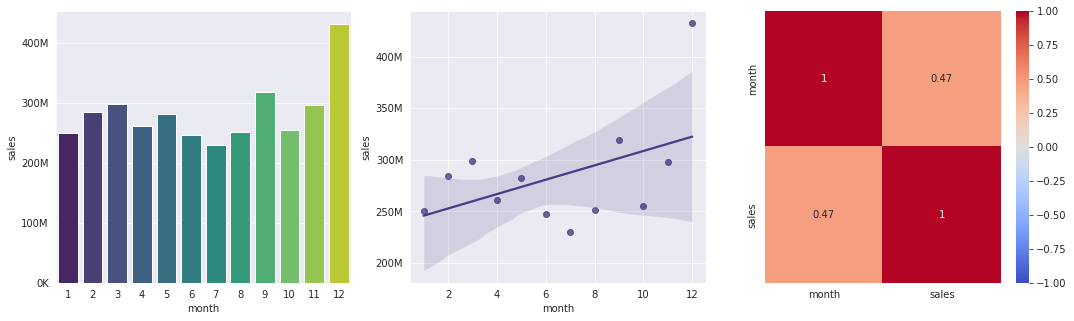

In [370]:
#@title Plot and Correlation of Sales x Months
plt.figure(figsize=(18,5))

aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
g1 = sns.barplot(x='month',y='sales',data=aux1,palette='viridis')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,2)
g2 = sns.regplot(x='month',y='sales',data=aux1,color=viridis)
g2.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True,cmap='coolwarm',vmax=1,vmin=-1)

plt.show()

### $H_{3}:$ Stores should sell more in the first half of the month
**FALSE** $\Rightarrow$ Stores sell MORE after the 15th DAY

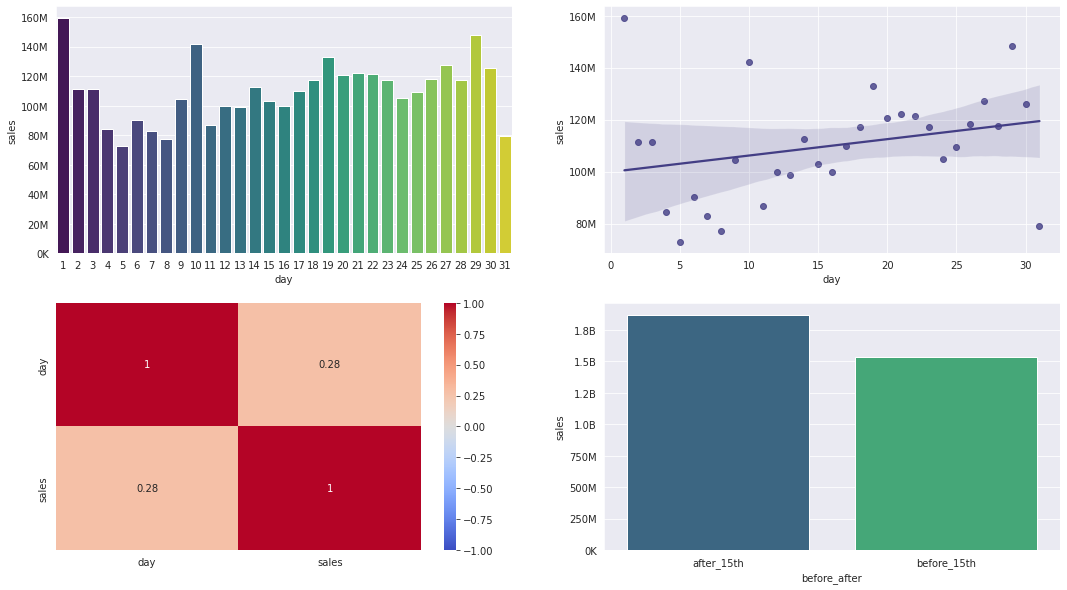

In [371]:
#@title Plot and Correlation of Sales x Days
plt.figure(figsize=(18,10))

aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
g1 = sns.barplot(x='day',y='sales',data=aux1,palette='viridis')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))


plt.subplot(2,2,2)
g2 = sns.regplot(x='day',y='sales',data=aux1,color=viridis)
g2.yaxis.set_major_formatter(tick.FuncFormatter(format_number))


plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True,cmap='coolwarm',vmax=1,vmin=-1)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_15th' if x <=15 else 'after_15th')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
g4 = sns.barplot(x='before_after',y='sales',data=aux2,palette='viridis')
g4.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

### $H_{4}:$ Stores should sell more on weekends
**TRUE** $\Rightarrow$ Stores sell MORE on weekends

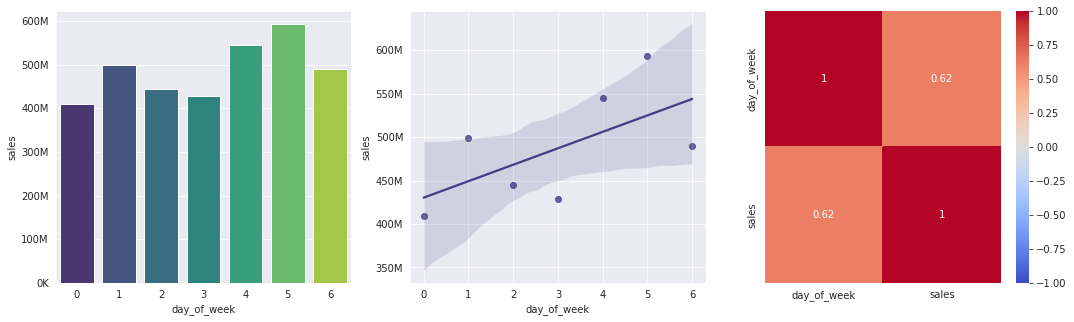

In [372]:
#@title Plot and Correlation of Sales x Day of Week
plt.figure(figsize=(18,5))

aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
g1 = sns.barplot(x='day_of_week',y='sales',data=aux1,palette='viridis')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,2)
g2 = sns.regplot(x='day_of_week',y='sales',data=aux1,color=viridis)
g2.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True,cmap='coolwarm',vmax=1,vmin=-1)

plt.show()

### $H_{5}:$ Store located in Moscow should sell more
**TRUE** $\Rightarrow$ Stores located in Moscow SELL MORE

In [373]:
aux1 = df4[df4['city']!='Exit']
aux2 = pd.concat([aux1[['sales','city']].groupby('city').sum().reset_index(),
                 aux1[['sales','city']].groupby('city').mean().reset_index()['sales']],
                 axis=1)
aux2.columns = ['city','total_sales','mean_sales']
aux2.sort_values('mean_sales',ascending=False,inplace=True)

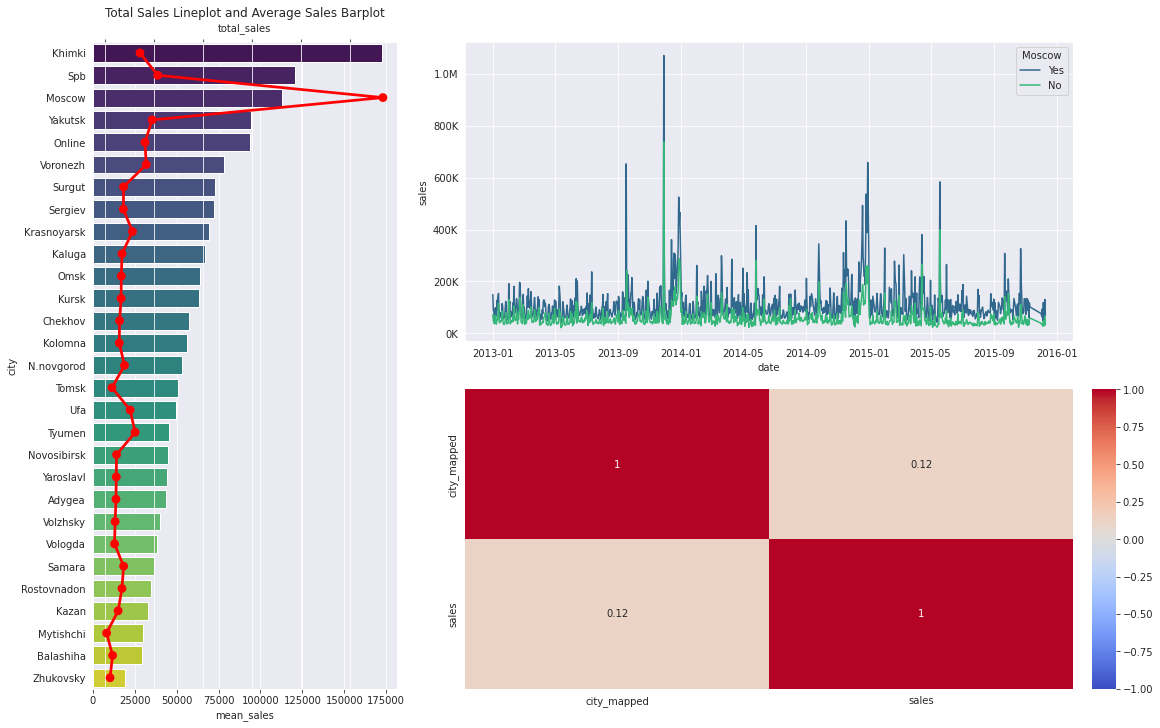

In [374]:
#@title Hypothesis 5 Plots

fig = plt.figure(constrained_layout=True,figsize=(16,10))
spec = fig.add_gridspec(nrows=2,ncols=3)

axes1 = fig.add_subplot(spec[0:, 0])
# Barplot - Average Sales
g1 = sns.barplot(data=aux2,y='city',x='mean_sales',ax=axes1,palette='viridis',label='Average Sales')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

# Lineplot - Total Sales 
axes2 = plt.twiny()
g2 = sns.pointplot(x='total_sales', y='city',ax=axes2 ,data=aux2,color='r',label='Total Sales').set(xticklabels=[])
plt.title('Total Sales Lineplot and Average Sales Barplot')

# Timeline of Sales
axes3 = fig.add_subplot(spec[0, 1:])
aux1['Moscow'] = aux1['city'].map(lambda x: 'Yes' if x=='Moscow' else 'No')
aux3 = aux1[['date','Moscow','sales']].groupby(['date','Moscow']).mean().reset_index()
g3 = sns.lineplot(data=aux3,x='date',y='sales',hue='Moscow',palette='viridis',ax=axes3,hue_order=['Yes','No'])
g3.yaxis.set_major_formatter(tick.FuncFormatter(format_number))


# Correlation Heatmap
axes4 = fig.add_subplot(spec[1:, 1:])
city_dict = dict(zip(aux1['city'].unique(),list(range(29,-1,-1))))
aux1['city_mapped'] = aux1.city.map(city_dict)
g4 = sns.heatmap(aux1[['city_mapped','sales']].corr(method='pearson'),ax=axes4,annot=True,cmap='coolwarm',vmax=1,vmin=-1)

plt.show()

### $H_{6}:$ Shopping Center type stores should sell more
**FALSE** $\Rightarrow$ Stores with 'TC shop type' SELLS MORE than Shopping Center


In [375]:
aux1 = pd.concat([df4[['sales','shop_type']].groupby('shop_type').sum().reset_index(),
                 df4[['sales','shop_type']].groupby('shop_type').mean().reset_index()['sales']],
                 axis=1)
aux1.columns = ['shop_type','total_sales','mean_sales']
aux1.sort_values('mean_sales',ascending=False,inplace=True)

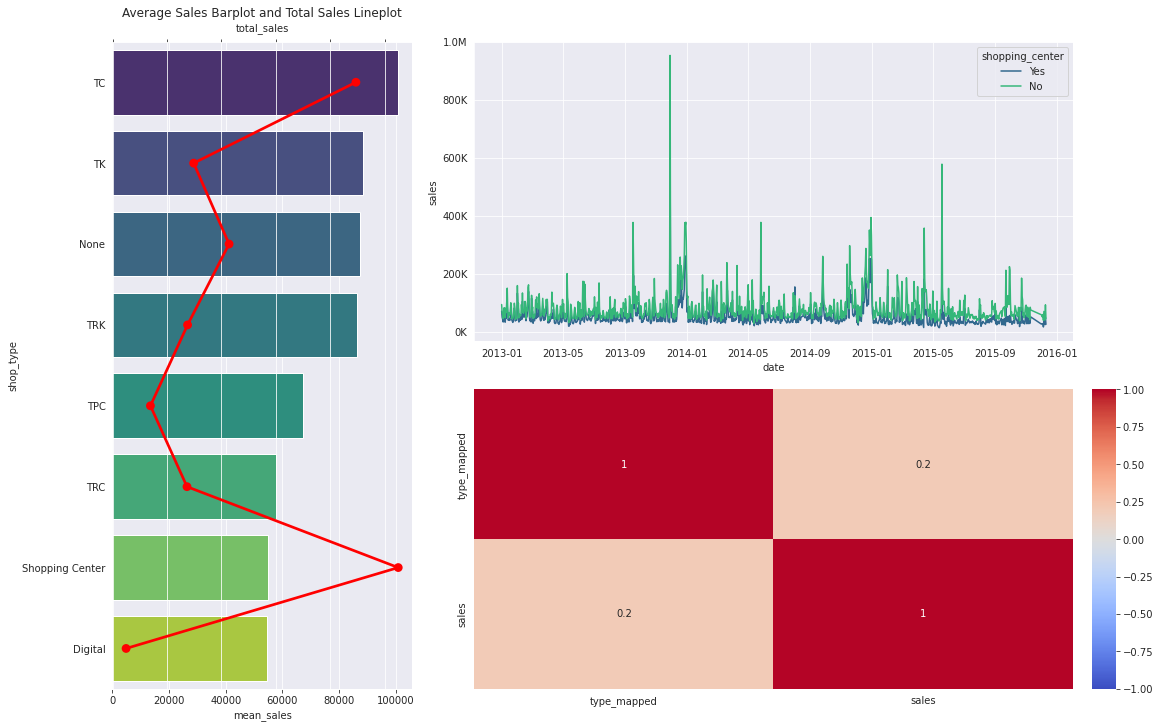

In [377]:
#@title Hypothesis 6 Plots

fig = plt.figure(constrained_layout=True,figsize=(16,10))
spec = fig.add_gridspec(nrows=2,ncols=3)

# Barplot - Average Sales
axes1 = fig.add_subplot(spec[0:, 0])
g1 = sns.barplot(data=aux1,y='shop_type',x='mean_sales',ax=axes1,palette='viridis',label='Average Sales')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

# Lineplot - Total Sales 
axes2 = plt.twiny()
g2 = sns.pointplot(x='total_sales', y='shop_type',ax=axes2 ,data=aux1,color='r',label='Total Sales').set(xticklabels=[])
plt.title('Average Sales Barplot and Total Sales Lineplot')

# Timeline of Sales
axes3 = fig.add_subplot(spec[0, 1:])
df4['shopping_center'] = df4['shop_type'].map(lambda x: 'Yes' if x=='Shopping Center' else 'No')
aux2 = df4[['date','shopping_center','sales']].groupby(['date','shopping_center']).mean().reset_index()
g3 = sns.lineplot(data=aux2,x='date',y='sales',hue='shopping_center',palette='viridis',ax=axes3,hue_order=['Yes','No'])
g3.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

# Correlation Heatmap
axes4 = fig.add_subplot(spec[1:, 1:])
type_dict = dict(zip(aux1['shop_type'].unique(),list(range(8,-1,-1))))
df4['type_mapped'] = df4.shop_type.map(type_dict)
g4 = sns.heatmap(df4[['type_mapped','sales']].corr(method='pearson'),ax=axes4,annot=True,cmap='coolwarm',vmax=1,vmin=-1)

df4.drop(['type_mapped','shopping_center'],axis=1,inplace=True)

plt.show()

In [314]:
df4[['date','sales']].sort_values('sales',ascending=False)

df4[(df4['date']==datetime.datetime(2015,5,19))]
# & (df4['sales']==3882146.00)]

,date,item_price,item_name,item_category_name,shop_name,simple_categories,city,shop_type,year,month,day,week_of_year,year_week,day_of_week,sales,holiday,item_variety,shop_average_price
9485,2015-05-19,249.00,Circle Mikhail Laughty Song (firms),Music - Local CD CD,"Yaroslavl shopping center ""Altair""",Music,Yaroslavl,Shopping Center,2015,5,19,21,2015-20,1,146617.00,0,42108,36109.29
10865,2015-05-19,1600.00,Reception of funds for 1C-online,Service,"Yaroslavl shopping center ""Altair""",Service,Yaroslavl,Shopping Center,2015,5,19,21,2015-20,1,146617.00,0,42108,36109.29
22147,2015-05-19,5.00,Brand Package Mike 1C Interest White (34 * 42)...,"Gifts - Bags, Albums, Rugs D / Mouse","Yaroslavl shopping center ""Altair""",Gifts,Yaroslavl,Shopping Center,2015,5,19,21,2015-20,1,146617.00,0,42108,36109.29
26680,2015-05-19,169.00,Ralph (region),Cinema - DVD.,"Yaroslavl shopping center ""Altair""",Cinema,Yaroslavl,Shopping Center,2015,5,19,21,2015-20,1,146617.00,0,42108,36109.29
29059,2015-05-19,26990.00,Sony PlayStation 4 (500 GB) Black (CUH-1008A /...,Gaming Consoles - PS4,"Yaroslavl shopping center ""Altair""",Gaming Consoles,Yaroslavl,Shopping Center,2015,5,19,21,2015-20,1,146617.00,0,42108,36109.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934723,2015-05-19,500.00,"Handy Backup Standard 7 (Novosoft) [PC, digita...",Programs - for home and office (digit),1c-online digital warehouse,Programs,Online,Digital,2015,5,19,21,2015-20,1,120584.00,0,34769,23124.57
2934868,2015-05-19,699.00,"Batman: Arkhem Knight. SEASON PASS [PC, digita...",PC games - digit,1c-online digital warehouse,PC games,Online,Digital,2015,5,19,21,2015-20,1,120584.00,0,34769,23124.57
2934921,2015-05-19,999.00,"Witcher 3: Wild hunting. Addition set [PC, dig...",PC games - digit,1c-online digital warehouse,PC games,Online,Digital,2015,5,19,21,2015-20,1,120584.00,0,34769,23124.57
2934990,2015-05-19,2099.00,"Witcher 3: Wild Hunt + Addition Set [PC, Digit...",PC games - digit,1c-online digital warehouse,PC games,Online,Digital,2015,5,19,21,2015-20,1,120584.00,0,34769,23124.57


### $H_{7}:$ Stores should sell less on holidays
**FALSE** $\Rightarrow$ There isn't a correlation between sales on and off holidays


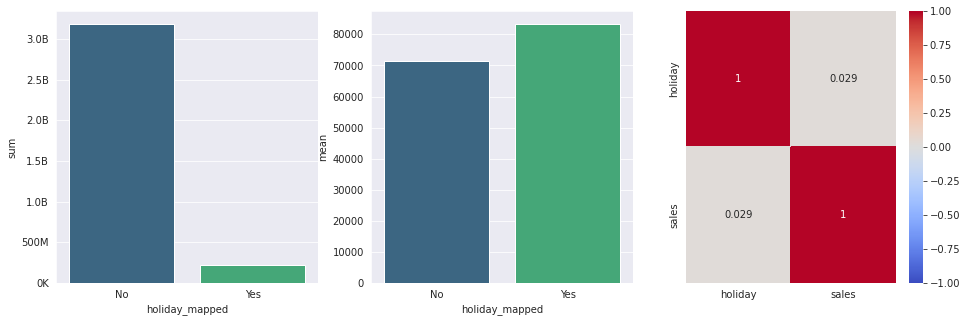

In [378]:
#@title Hypothesis 7 Plots

plt.figure(figsize=(16,5))

aux1 = df4[['holiday','sales']].groupby('holiday')['sales'].agg(['sum','mean']).reset_index()
aux1['holiday_mapped'] = aux1['holiday'].replace({0:'No',1:'Yes'})

plt.subplot(1,3,1)
g1 = sns.barplot(data=aux1, x='holiday_mapped', y='sum',palette='viridis')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,2)
g2 = sns.barplot(data=aux1, x='holiday_mapped', y='mean',palette='viridis')

plt.subplot(1,3,3)
g3 = sns.heatmap(df4[['holiday','sales']].corr(),cmap='coolwarm',vmax=1,vmin=-1,annot=True)

### $H_{8}:$ Stores with more item variety should sell more
**TRUE** $\Rightarrow$ Total sales increases along with item variety

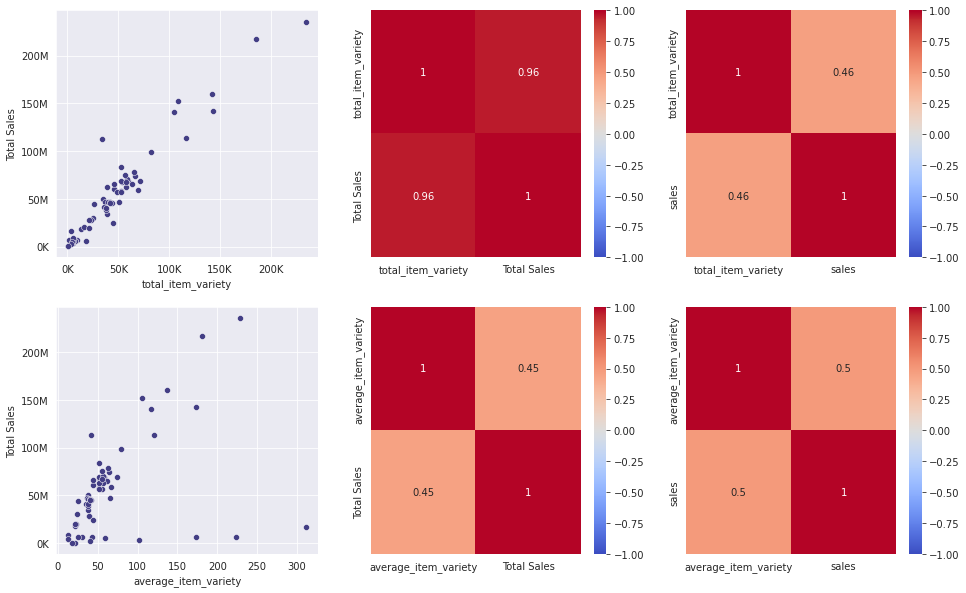

In [401]:
#@title Hypothesis 8 plots
plt.figure(figsize=(16,10))

aux1 = df4[['shop_name','item_name','sales']].groupby('shop_name').agg({'item_name':'sum','sales': 'sum'}).reset_index().rename(columns={'item_name':'total_item_variety','sales':'Total Sales'})
aux2 = df4[['shop_name','item_name','sales']].groupby('shop_name').agg({'item_name':'mean','sales': 'sum'}).reset_index().rename(columns={'item_name':'average_item_variety','sales':'Total Sales'})
aux3 = pd.merge(aux1,aux2[['shop_name','average_item_variety']],on='shop_name')

plt.subplot(2,3,1)
g1 = sns.scatterplot(data=aux3,x='total_item_variety',y='Total Sales',color=viridis)
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))
g1.xaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(2,3,2)
sns.heatmap(aux1[['total_item_variety','Total Sales']].corr(),vmin=-1,vmax=1,annot=True,cmap='coolwarm')

df4 = pd.merge(df4,aux3.drop('Total Sales',axis=1),on='shop_name')
plt.subplot(2,3,3)
sns.heatmap(df4[['total_item_variety','sales']].corr(),vmin=-1,vmax=1,annot=True,cmap='coolwarm')

plt.subplot(2,3,4)
g2 = sns.scatterplot(data=aux3,x='average_item_variety',y='Total Sales',color=viridis)
g2.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(2,3,5)
sns.heatmap(aux2[['average_item_variety','Total Sales']].corr(),vmin=-1,vmax=1,annot=True,cmap='coolwarm')

plt.subplot(2,3,6)
sns.heatmap(df4[['average_item_variety','sales']].corr(),vmin=-1,vmax=1,annot=True,cmap='coolwarm')

plt.show()

### $H_{9}:$ Stores with higher sums of average prices should sell more
**TRUE** $\Rightarrow$ Stores with higher sums of average prices SELL MORE

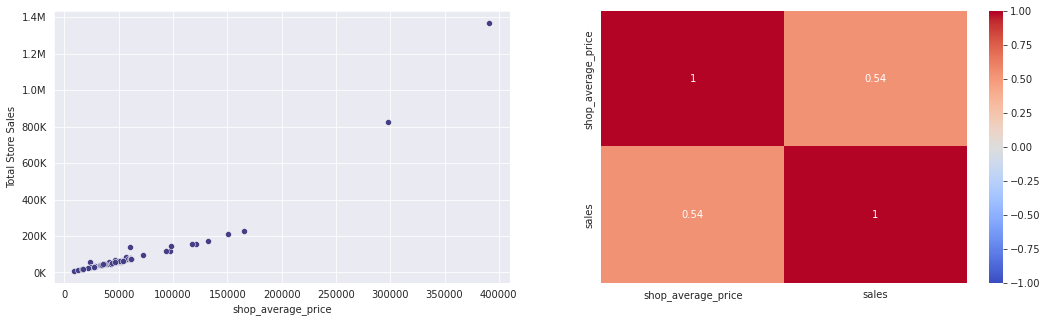

In [402]:
#@title Hypothesis 9 Plots
plt.figure(figsize=(18,5))

aux0 = df4[['shop_name','date','item_price']].groupby(['shop_name','date']).sum().reset_index().groupby('shop_name').mean().reset_index()
price_dict = dict(zip(aux0['shop_name'], aux0['item_price']))
df4['shop_average_price'] = df4['shop_name'].map(price_dict)

plt.subplot(1,2,1)
g1 = sns.scatterplot(data=df4[['shop_name','shop_average_price','sales']].groupby('shop_name').mean().reset_index(),
                     x='shop_average_price',
                     y='sales',
                     color=viridis)
plt.ylabel('Total Store Sales')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,2,2)
sns.heatmap(df4[['shop_average_price','sales']].corr(),vmin=-1,vmax=1,annot=True,cmap='coolwarm')

plt.show()

### 4.2.1. Summary of Hypothesis

In [267]:
#@title Relevance of the Conclusions of Hypothesis
tab = [['Hypothesis','Conclusion','Relevance'],
       ['H1','False','High'],
       ['H2','False','Medium'],
       ['H3','False','Low'],
       ['H4','True','High'],
       ['H5','True','Low'],
       ['H6','False','Low'],
       ['H7','False','Low'],
       ['H8','True','Medium'],
       ['H9','True','High']]
print(tabulate(tab,headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         High
H2            False         Medium
H3            False         Low
H4            True          High
H5            True          Low
H6            False         Low
H7            False         Low
H8            True          Medium
H9            True          High


## 4.3. Multivariate Analysis


### 4.3.1. Numerical Attributes

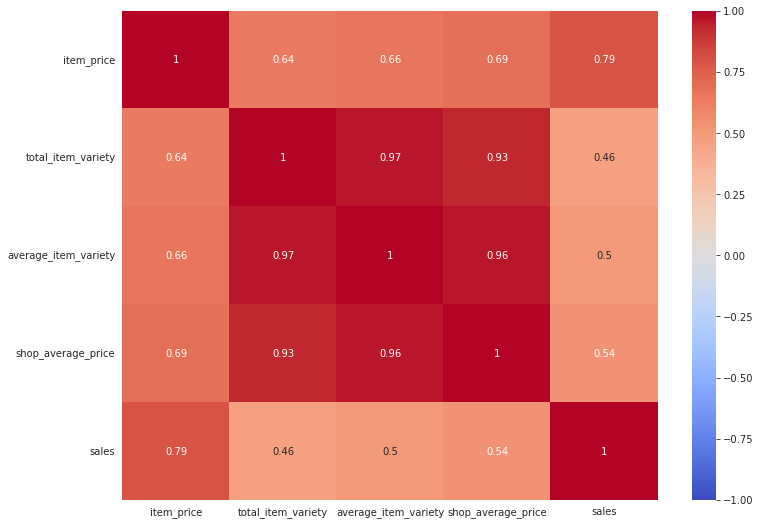

In [403]:
plt.figure(figsize=(12,9))
correlation = df4[['item_price','total_item_variety','average_item_variety','shop_average_price','sales']].corr(method='pearson')
sns.heatmap(correlation,annot=True,cmap='coolwarm',vmin=-1, vmax=1)
plt.show()

### 4.3.2. Categorical Attributes

In [404]:
a = df4.select_dtypes(include=object)

a1 = cramer_v(a['shop_name'],a['shop_name'])
a2 = cramer_v(a['shop_name'],a['city'])
a3 = cramer_v(a['shop_name'],a['shop_type'])

a4 = cramer_v(a['city'],a['shop_name'])
a5 = cramer_v(a['city'],a['city'])
a6 = cramer_v(a['city'],a['shop_type'])

a7 = cramer_v(a['shop_type'],a['shop_name'])
a8 = cramer_v(a['shop_type'],a['city'])
a9 = cramer_v(a['shop_type'],a['shop_type'])

correlation2 = pd.DataFrame( {'shop_name': [a1,a2,a3],
                              'city': [a4,a5,a6],
                              'shop_type': [a7,a8,a9]})

correlation2 = correlation2.set_index(correlation2.columns)

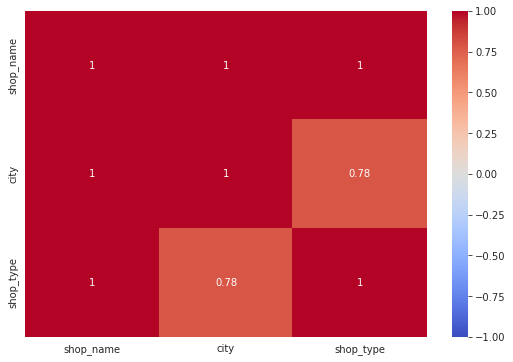

In [405]:
plt.figure(figsize=(9,6))
sns.heatmap(correlation2,annot=True,cmap='coolwarm',vmin=-1, vmax=1)
plt.show()

# 5. Data Preparation

In [406]:
df5 = df4.copy()

## 5.1. Normalization

### No Gaussian Distributions were found
- Because of this, we won't perform normalization on any of the variables;


## 5.2. Rescaling

### 5.2.1. Year

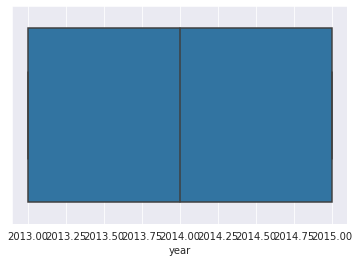

In [407]:
#@title Boxplot of Year
sns.boxplot(df5['year'])
plt.show()

In [408]:
mms = MinMaxScaler()
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. Data Transformation

### 5.3.1. Encoding

In [409]:
df5.dtypes

shop_name                       object
date                    datetime64[ns]
city                            object
shop_type                       object
year_week                       object
item_price                     float64
item_name                        int64
year                           float64
month                            int64
day                              int64
week_of_year                     int64
day_of_week                      int64
sales                          float64
holiday                          int64
total_item_variety               int64
average_item_variety           float64
shop_average_price             float64
dtype: object

In [411]:
df5[['shop_name','city','shop_type','total_item_variety','average_item_variety','shop_average_price']].nunique()

shop_name               60
city                    30
shop_type                8
total_item_variety      60
average_item_variety    60
shop_average_price      60
dtype: int64

In [412]:
# shop_name - Label Encoding
le = LabelEncoder()
df5['shop_name'] = le.fit_transform(df5['shop_name'])

# city - Label Encoding
df5['city'] = le.fit_transform(df5['city'])

# shop_type - One Hot Encoding
df5 = pd.get_dummies(df5,prefix=['shop_type'],columns=['shop_type'])

# total_item_variety - Ordinal Encoding
variety_dict = dict(zip(sorted(df5['total_item_variety'].unique()),list(range(len(df5['total_item_variety'].unique())))))
df5['total_item_variety'] = df5['total_item_variety'].map(variety_dict)

# average_item_variety - Ordinal Encoding
variety_dict = dict(zip(sorted(df5['average_item_variety'].unique()),list(range(len(df5['average_item_variety'].unique())))))
df5['average_item_variety'] = df5['average_item_variety'].map(variety_dict)

# shop_average_price - Ordinal Encoding
iqr_dict = dict(zip(sorted(df5['shop_average_price'].unique()),list(range(len(df5['shop_average_price'].unique())))))
df5['shop_average_price'] = df5['shop_average_price'].map(iqr_dict)

### 5.3.2. Response Variable Transformation

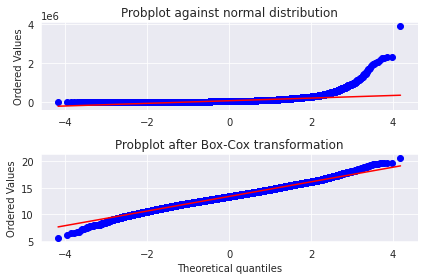

In [413]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(df5['sales'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(df5['sales'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')

plt.tight_layout()
plt.show()

In [414]:
df5['sales'] = stats.boxcox(df5['sales'])[0]

### 5.3.3. Nature Transformation

In [415]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. * np.pi/52)))

# day of the week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))

# 6. Feature Selection

In [416]:
df6 = df5.copy()

## 6.1. Training and Test Dataset Split

In [418]:
# Dropping unnecessary columns
cols_drop = ['item_price',
             'item_name',
             'month',
             'day',
             'week_of_year',
             'year_week',
             'day_of_week',
             'holiday']
df6 = df6.drop(cols_drop,axis=1)

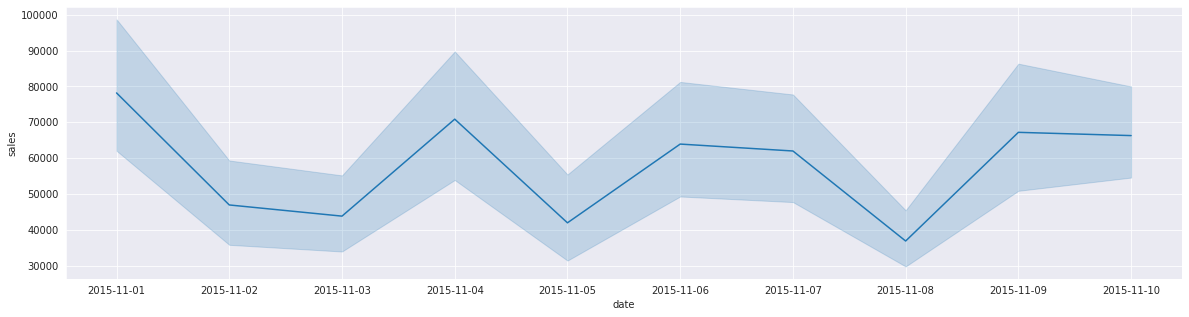

In [431]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df4[(df4['year']==2015)&(df4['month']==11)],x='date',y='sales')

In [425]:
df4['year'].value_counts()

2014    17668
2013    16256
2015    13293
Name: year, dtype: int64

In [304]:
# Three months before the last update
df6[['shop_name','date']].groupby('shop_name').max().reset_index()['date'].max() - datetime.timedelta(days=3*30)

Timestamp('2015-09-11 00:00:00')

In [ ]:
# Training Dataset
X_train = df6[df6['date'] < '2015-09-11']
y_train = X_train['sales']

# Test Dataset
X_test = df6[df6['date'] >= '2015-09-11']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-09-10 00:00:00

Test Min Date: 2015-09-13 00:00:00
Test Max Date: 2015-12-10 00:00:00


## 6.2. Feature Selecting w/ Boruta

In [ ]:
# training and test dataset for boruta
X_train_n = X_train.drop(['date','sales'],axis=1).values
y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# Define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=101)

In [ ]:
# Find all relevant features
feat_selector.fit(X_train_n, y_train_n)

In [ ]:
cols_selected = feat_selector.support_.tolist()

X_train_fs = X_train.drop(['date','sales'],axis=1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

In [ ]:
cols_selected_boruta

In [ ]:
cols_not_selected_boruta

In [ ]:
cols_selected_boruta = ['shop_name',
                        'city',
                        'year',
                        'item_variety',
                        'shop_IQR',
                        'shop_type_Digital',
                        'shop_type_None',
                        'shop_type_Shopping Center',
                        'shop_type_TC',
                        'shop_type_TK',
                        'shop_type_TPC',
                        'shop_type_TRC',
                        'shop_type_TRK',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos',
                        'day_of_week_sin',
                        'day_of_week_cos']

# Columns to add
feat_to_add = ['date','sales']

# Finall features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# Training for cross validation
x_training = X_train[cols_selected_boruta_full]

# 7. Machine Learning Modeling

In [ ]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1. Average Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['shop_name','sales']].groupby('shop_name').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='shop_name')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average Model',np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,30.243383,1.829374,82.75697


## 7.2. Linear Regression Model

In [ ]:
# Model
lr = LinearRegression().fit(x_train,y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,39.504717,0.572181,91.992457


### 7.2.1. Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation(x_training,5,'Linear Regression',lr)

## 7.3. Linear Regression Regularized Model - Lasso

In [ ]:
# Model
lrr = Lasso(alpha=0.01).fit(x_train,y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,40.982634,0.638685,92.069739


### 7.3.1. Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation(x_training,5,'Lasso',lrr)

## 7.4. Random Forest Regressor

In [ ]:
# Model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=101).fit(x_train,y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,36.404081,0.436155,90.24352


### 7.4.1. Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training,5,'Random Forest Regressor',rf)

## 7.5. XGBoost Regressor

In [ ]:
# Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.9).fit(x_train,y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost',np.expm1(y_test),np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost,30.040159,0.338792,85.040625


### 7.5.1. XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training,5,'XGBoost Regressor',model_xgb)

## 7.6. Model Performance Comparison

### 7.6.1. Single Performance

In [ ]:
models_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
models_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Average Model,30.243383,1.829374,82.756970
0,XGBoost,30.040159,0.338792,85.040625
0,Random Forest,36.404081,0.436155,90.243520
0,Linear Regression,39.504717,0.572181,91.992457
0,Linear Regression,40.982634,0.638685,92.069739


### 7.6.2. Real Performance - Cross Validation

In [ ]:
models_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
models_result_cv

,Model Name,MAE Mean,MAPE Mean,RMSE Mean
0,Linear Regression,50.71 +/- 20.31,0.47 +/- 0.05,91.18 +/- 48.86
0,Lasso,51.87 +/- 20.98,0.52 +/- 0.04,91.89 +/- 51.3
0,Random Forest Regressor,46.0 +/- 14.42,0.41 +/- 0.04,80.9 +/- 28.33
0,XGBoost Regressor,39.47 +/- 14.47,0.35 +/- 0.04,74.0 +/- 34.08


# 8. Hyperparameter Fine Tuning

## 8.1. Random Search

In [ ]:
# Parameters that going to be used
param = {
        'n_estimators':[1500,1700,2500,3000,3500],
        'eta':[0.01,0.03],
        'max_depth':[3,5,9],
        'subsample':[0.1,0.5,0.7],
        'colsample_bytee':[0.3,0.7,0.9],
        'min_child_weight':[3,8,15]
         }

In [ ]:
final_result = pd.DataFrame()

for i in range(2):
  # Choose values for parameters randomly
  hp = {k:random.sample(v,1)[0] for k, v in param.items()}
  print(hp)
  
  # Model
  model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=hp['n_estimators'],
                              eta=hp['eta'],
                              max_depth=hp['max_depth'],
                              subsample=hp['subsample'],
                              colsample_bytee=hp['colsample_bytee'],
                              min_child_weight=hp['min_child_weight'])

  # Performance
  result = cross_validation(x_training,2,'XGBoost Regressor',model_xgb)
  final_result = pd.concat([final_result,result])

final_result

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 15}


,Model Name,MAE Mean,MAPE Mean,RMSE Mean
0,XGBoost Regressor,29.82 +/- 4.69,0.34 +/- 0.01,55.35 +/- 17.05
0,XGBoost Regressor,29.49 +/- 6.06,0.33 +/- 0.03,58.99 +/- 23.12


In [ ]:
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 3}

# Creating final model
xgb_final_model = xgb.XGBRegressor(objective='reg:squarederror')

# Seting up random search meta-estimator
clf = RandomizedSearchCV(xgb_final_model, param, n_iter=20, cv=5, random_state=1)

# Train the random search meta-estimator to find the best model out of 20 candidates
final_model = clf.fit(x_training.drop(['date','sales'],axis=1), x_training['sales'])

In [ ]:
# Printting best Hyperparameters 
pprint(final_model.best_estimator_.get_params())

## 8.2. Final Model

In [ ]:
# Final Model
final_model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=3500,
                             eta=0.03,
                             max_depth=3,
                             subsample=0.1,
                             colsample_bytee=0.9,
                             min_child_weight=3).fit(x_train,y_train)

# Test dataset final prediction
final_yhat = final_model_xgb.predict(x_test)

# 9. Error Translation and Interpretation

In [ ]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(final_yhat)

In [ ]:
compression_opts = dict(method='zip',
                        archive_name='final_df.csv')  
df9.to_csv('final_df.zip', index=False,
          compression=compression_opts) 

## 9.1. Business Performance

In [ ]:
# sum of predictions
df91 = df9[['shop_name','predictions']].groupby('shop_name').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['shop_name','sales','predictions']].groupby('shop_name').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['shop_name','sales','predictions']].groupby('shop_name').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='shop_name')
df92 = pd.merge(df91, df9_aux3,how='inner', on='shop_name')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

In [ ]:
df92.sort_values('MAPE',ascending=False).head()

,shop_name,predictions,MAE,MAPE,worst_scenario,best_scenario
24,31,49033.109375,131.078787,5.445396,48902.030588,49164.188162
29,36,508.959900,7.111004,0.797731,501.848895,516.070904
27,34,275283.500000,155.990714,0.649172,275127.509286,275439.490714
6,10,117121.320312,74.346496,0.596692,117046.973816,117195.666809
21,28,4482.701660,22.580402,0.527022,4460.121259,4505.282062


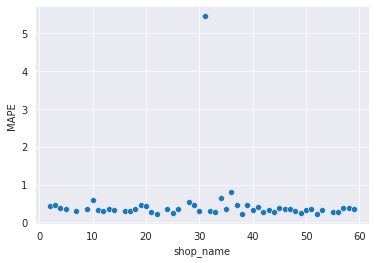

In [ ]:
sns.scatterplot(data=df92,x='shop_name',y='MAPE')

## 9.2. Total Performance

In [ ]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index':'Scenario',0:'Count'})
df93['Count'] = df93['Count'].map('{:,.0f}'.format)
df93

,Scenario,Count
0,predictions,"9,918,148"
1,worst_scenario,"9,916,885"
2,best_scenario,"9,919,409"


## 9.3. Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

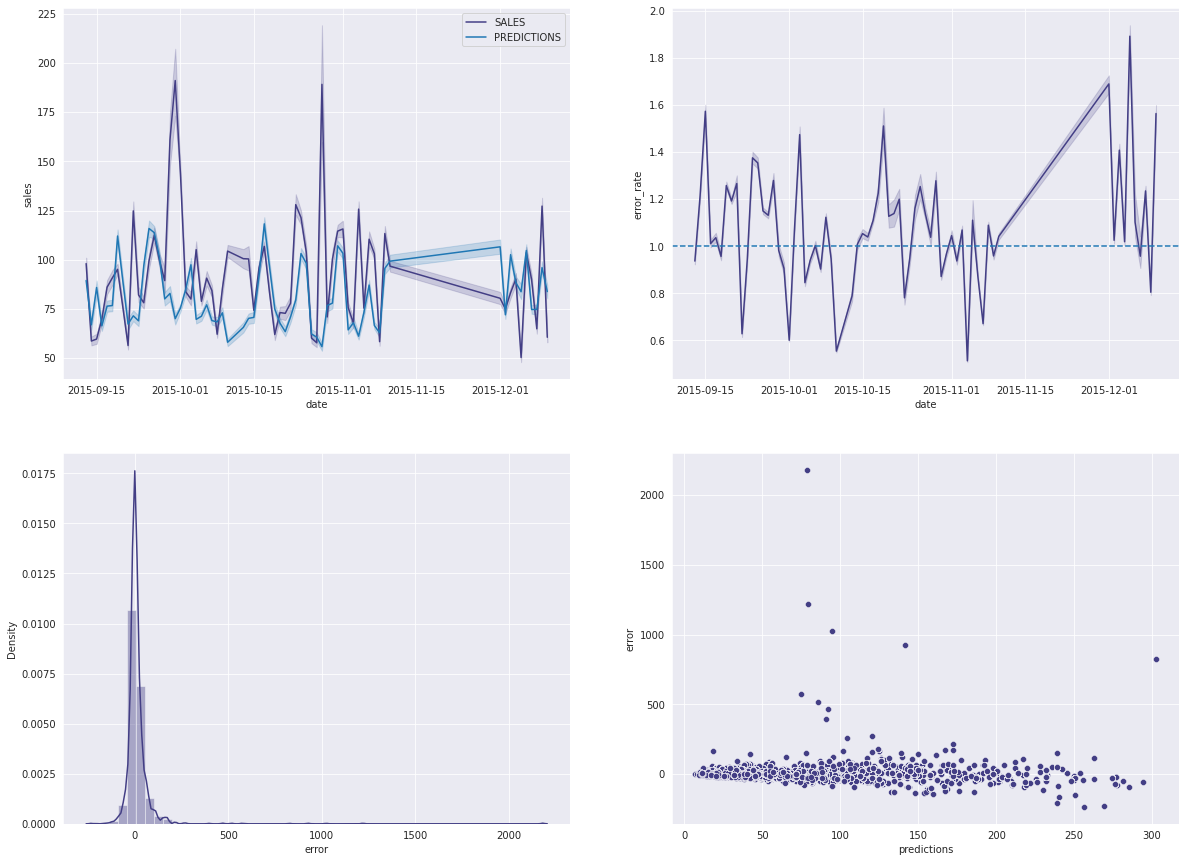

In [ ]:
plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='SALES',color=viridis)
sns.lineplot(x='date',y='predictions',data=df9,label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9,color=viridis)
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'],color=viridis)

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'],df9['error'],color=viridis)

plt.show()